In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay

import matplotlib.ticker as mtick
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

sns.set()

import pickle

import notebook_util as n_util
from notebook_util import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.autograd import Variable

In [2]:
from comet_ml import API

api = API()

api.download_registry_model("ift6758a-a22-g3-projet", "MLP1", "1.0.0",
                            output_path="../models/", expand=True)

COMET INFO: Downloading registry model 'MLP1', version '1.0.0', stage None from workspace 'ift6758a-a22-g3-projet'...
COMET INFO: Unzipping model to 'c:\\Users\\Bei Ning\\Documents\\GitHub\\ift6758-a22-g3-projet\\models' ...
COMET INFO: done!


In [7]:
df_filtered = prep_data(year_list = [20192020], gametype = 'P')

df_filtered = prep_dummie(df_filtered)

df_filtered['prevEvent_Goal'] = 0

df_filtered['prevEvent_Penalty'] = 0

c:\Users\Bei Ning\Documents\GitHub\ift6758-a22-g3-projet\notebooks\notebook_util.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['emptyNet'] = df_filtered['emptyNet'].fillna(0)
c:\Users\Bei Ning\Documents\GitHub\ift6758-a22-g3-projet\notebooks\notebook_util.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['strength'] = df_filtered['strength'].fillna('Even')


In [8]:
x_test = df_filtered[n_util.feature]

y_test = df_filtered['isGoal']

In [9]:
print(x_test.shape)
print(y_test.shape)

(7402, 35)
(7402,)


In [10]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.fc4(x)
        x = F.sigmoid(x)
        
        return x

In [11]:
# open a file, where you stored the pickled data
file = open('../models/MLP1.sav', 'rb')

# dump information to that file
net = pickle.load(file)

# close the file
file.close()

In [12]:
x_test_t = torch.tensor(x_test.to_numpy(dtype=np.float32), dtype = torch.float32)
y_test_t = torch.tensor(y_test.values, dtype = torch.float32)

In [13]:
# Evaluate the model
test_var = Variable(torch.FloatTensor(x_test_t), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
values = torch.round(result[:, 0])

num_right = np.sum(values.data.numpy().astype(int) == y_test)
print('Num Right', num_right)
accuracy = num_right / len(y_test_t)
print('Accuracy {:.2f}'.format(accuracy))

Num Right 5025
Accuracy 0.68


c:\Anaconda\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [14]:
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import BinaryF1Score

target_m = torch.tensor(y_test.to_numpy()).to(torch.int)
pred_m = torch.tensor(values).to(torch.int)

confmat = ConfusionMatrix(num_classes=2)
confmat(target_m, pred_m)

C:\Users\Bei Ning\AppData\Local\Temp\ipykernel_9588\1599096580.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_m = torch.tensor(values).to(torch.int)


tensor([[4515,  138],
        [2239,  510]])

In [15]:
metric = BinaryF1Score()
print('F1 Pytorch')
print(metric(result[:, 0], target_m).item())
from sklearn.metrics import f1_score
f1 = f1_score(target_m.numpy(), values.numpy().astype(int), average='macro')
print('F1 Sklearn Macro')
print(f1)

F1 Pytorch
0.3002649247646332
F1 Sklearn Macro
0.5459420604285792


In [16]:
fpr, tpr, threshold = metrics.roc_curve(y_test, result[:, 0].numpy())
roc_auc = metrics.auc(fpr, tpr)

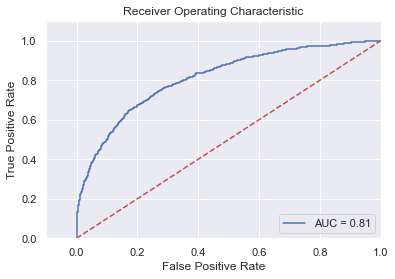

In [17]:
show_roc(fpr, tpr, roc_auc)

In [18]:
y_test_pred = values.numpy().astype(int)
score_prob = result[:, 0].numpy()

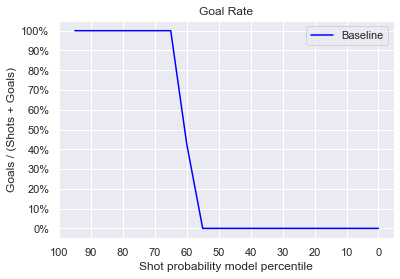

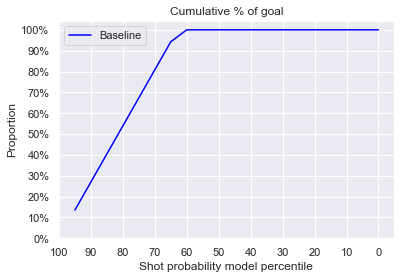

In [19]:
built_array, index_array, goal_array, total_goal = prepare_goal_rate(y_test_pred, score_prob)
create_goal_rate_plot(index_array, built_array)
cumulative_array = compute_cumulative(goal_array, total_goal)
create_cumulative_plot(np.flip(index_array), cumulative_array)

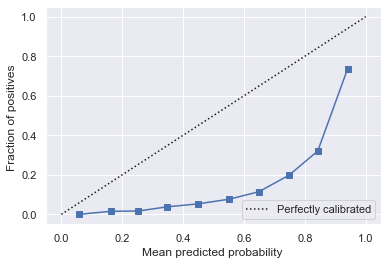

In [20]:
prob_true, prob_pred = calibration_curve(y_test, score_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, score_prob).plot()
plt.show()

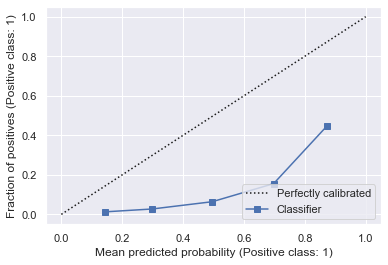

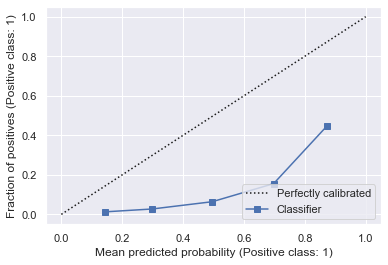

In [21]:
disp = CalibrationDisplay.from_predictions(y_test, score_prob).plot()
plt.show()